# Linear models on combined data

This notebook combines the datasets from the prior two notebooks to conduct an interrupted time-series analysis, intending to find out whether changes in the universal admission testing policy associated with significant immediate level changes in the rates of hospital-onset COVID (after normalizing them to estimates or correlates of community prevalence).

In [1]:
suppressMessages({
    require(plyr)
    require(tidyverse)
    require(data.table)
    require(readxl)
    require(viridis)
    require(ggplot2)
    require(yaml)
    require(cowplot)
    require(lubridate)
    require(nlme)
    require(AICcmodavg)
})

options(repr.plot.res=224)
options(scipen=999)

In [2]:
dt.england <- readRDS(file="data/dt.england.rds")
dt.scotland <- readRDS(file="data/dt.scotland.rds")
dt.all <- rbind(dt.england, dt.scotland)
dt.all[, region := factor(region)]
str(dt.all)

Classes ‘data.table’ and 'data.frame':	260 obs. of  23 variables:
 $ date_range                              : chr  "03 August 2020 to 09 August 2020" "07 August 2020 to 13 August 2020" "14 August 2020 to 20 August 2020" "19 August 2020 to 25 August 2020" ...
 $ est_pct_positive                        : num  0.05 0.05 0.05 0.05 0.07 0.11 0.19 0.21 0.41 0.62 ...
 $ est_pct_positive_ci95_lo                : num  0.03 0.03 0.04 0.04 0.05 0.09 0.16 0.18 0.37 0.57 ...
 $ est_pct_positive_ci95_hi                : num  0.07 0.06 0.07 0.07 0.1 0.14 0.23 0.24 0.45 0.66 ...
 $ est_pop_positive                        : num  28300 24600 28200 27100 39700 ...
 $ est_pop_positive_ci95_lo                : num  19000 16900 20100 19300 29300 ...
 $ est_pop_positive_ci95_hi                : num  40700 33800 37900 36700 52700 ...
 $ est_ratio_positive                      : chr  "1 in 2,000" "1 in 2,200" "1 in 1,900" "1 in 2,000" ...
 $ est_ratio_positive_ci95_lo              : chr  "1 in 3,300" "1 in 3,

From the prior notebooks, we've determined that our time period of interest starts in July 1 2021, during a nadir in community-onset and hospital-onset rates, and after a majority of UK citizens have received at least one dose of the vaccine. We also ensure any data after Dec 16 2022, which is ~7d into a period of missing ONS data and therefore not able to be used for a time series of weekly rates, are excluded from the analytic period.

In [3]:
date_study_start <- as.Date('2021-07-01')
date_study_end <-  as.Date('2022-12-16')
date_omicron_takeover <- as.Date("2021-12-14")
last_ons_date <- max(dt.all$date_hi)
last_ons_date
date_study_end

[1] "2022-12-09"

[1] "2022-12-16"

Let's define the dates on which [England](https://www.gov.uk/government/news/regular-asymptomatic-testing-paused-in-additional-settings) and [Scotland](https://www.gov.scot/news/pausing-asymptomatic-covid-19-testing/) stopped universal admission testing.

In [4]:
dt.asx_test_stopped <- data.table(
    region = factor(c("England", "Scotland")),
    stop_date = as.Date(c("2022-08-31", "2022-09-28"))
)
stop_dates <- dt.asx_test_stopped$stop_date
names(stop_dates) <- dt.asx_test_stopped$region
dt.asx_test_stopped 

region,stop_date
<fct>,<date>
England,2022-08-31
Scotland,2022-09-28


Finally, filter the dataset to the analytic period.

In [5]:
dt.study_period <- dt.all[date >= date_study_start & date <= date_study_end, ]
nrow(dt.study_period)

[1] 153

In [6]:
tail(dt.study_period[region == "England"])

date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,⋯,community_onset_adm_count,total_covid_adm_count,hospital_onset_adm_count,hospital_onset_ratio,hospital_onset_vs_comm_ratio,hospital_onset_vs_comm_positivity,hospital_onset_vs_comm_positives,hospital_onset_vs_comm_positives_ci95_hi,hospital_onset_vs_comm_positives_ci95_lo,region
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
02 November 2022 to 08 November 2022,1.73,1.63,1.82,940700,888600,994200,1 in 60,1 in 60,1 in 55,⋯,2592,3564,972,0.2727273,0.3750000,561.8497,0.001033273,0.001093856,0.0009776705,England
09 November 2022 to 15 November 2022,1.48,1.39,1.58,809200,757900,862600,1 in 65,1 in 70,1 in 65,⋯,2390,3326,936,0.2814191,0.3916318,632.4324,0.001156698,0.001234991,0.0010850916,England
20 November 2022 to 26 November 2022,1.73,1.60,1.86,941700,874100,1013600,1 in 60,1 in 60,1 in 55,⋯,2385,3380,995,0.2943787,0.4171908,575.1445,0.001056600,0.001138314,0.0009816496,England
29 November 2022 to 05 December 2022,2.01,1.87,2.15,1095100,1022000,1173500,1 in 50,1 in 55,1 in 45,⋯,2625,3936,1311,0.3330793,0.4994286,652.2388,0.001197151,0.001282779,0.0011171709,England
03 December 2022 to 09 December 2022,2.20,2.08,2.32,1197200,1135000,1263900,1 in 45,1 in 50,1 in 45,⋯,2955,4642,1687,0.3634209,0.5708968,766.8182,0.001409121,0.001486344,0.0013347575,England
03 December 2022 to 09 December 2022,2.20,2.08,2.32,1197200,1135000,1263900,1 in 45,1 in 50,1 in 45,⋯,3923,6306,2383,0.3778941,0.6074433,1083.1818,0.001990478,0.002099559,0.0018854340,England


## Interrupted time series models

In this model, we allow the slope and mean value within each period to be nonzero and vary freely between all three periods.

Below, we create additional variables to model the change in testing policy and potential slope changes. In accordance with usual interrupted time series analysis, we create them such that the _additive_ effect beyond the end of testing, or before the takeover of omicron, will be captured by the variable. (An alternative way is to create an interaction variable, such as `days_from_start * testing_stopped`, but this is less easy to interpret).

In [7]:
dt.study_period[, omicron_dominant := date > date_omicron_takeover]
dt.study_period[, testing_stopped := date > stop_dates[region]]
dt.study_period[, days_from_start := as.numeric(date - date_study_start)]
dt.study_period[, days_before_omicron_takeover := pmax(as.numeric(date_omicron_takeover - date), 0)]
dt.study_period[, days_from_testing_stopped := pmax(as.numeric(date - stop_dates[region]), 0)]
dt.study_period[
    seq(1, nrow(dt.study_period), 10),
    .(date, region, omicron_dominant, testing_stopped, 
        days_from_start, days_before_omicron_takeover, days_from_testing_stopped)
]

date,region,omicron_dominant,testing_stopped,days_from_start,days_before_omicron_takeover,days_from_testing_stopped
<date>,<fct>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
2021-07-02,England,FALSE,FALSE,1,165,0
2021-09-10,England,FALSE,FALSE,71,95,0
2021-11-19,England,FALSE,FALSE,141,25,0
2022-01-28,England,TRUE,FALSE,211,0,0
2022-04-08,England,TRUE,FALSE,281,0,0
2022-06-17,England,TRUE,FALSE,351,0,0
2022-08-26,England,TRUE,FALSE,421,0,0
2022-11-04,England,TRUE,TRUE,491,0,65
2021-07-25,Scotland,FALSE,FALSE,24,142,0


Let's create a helper function to succinctly summarize our model coefficients in a table.

The second function assists in converting these numbers to a nicer printable format, with proper minus symbols, two significant digits throughout, and confidence intervals.

In [8]:
summarize.gls.its <- function(gls.its, country) {
    counterfactual.delta <- predict(gls.its, newdata = data.table(
        days_from_start = as.numeric(date_omicron_takeover - date_study_start),
        omicron_dominant = FALSE,
        testing_stopped = FALSE,
        days_before_omicron_takeover = 0,
        days_from_testing_stopped = 0
    ))
    counterfactual.omi_w_tests <- predict(gls.its, newdata = data.table(
        days_from_start = as.numeric(stop_dates[country] - date_study_start),
        omicron_dominant = TRUE,
        testing_stopped = FALSE,
        days_before_omicron_takeover = 0,
        days_from_testing_stopped = 0
    ))
    counterfactual.delta
    counterfactual.omi_w_tests

    coef.mat <- cbind(summary(gls.its)$coefficients, confint(gls.its, level=0.95))
    coef.mat <- cbind(coef.mat, matrix(rep(NA, 3 * 6), ncol = 3))
    coef.mat["omicron_dominantTRUE", 4:6] <- coef.mat["omicron_dominantTRUE", 1:3] / counterfactual.delta * 100
    coef.mat["testing_stoppedTRUE", 4:6] <- coef.mat["testing_stoppedTRUE", 1:3] / counterfactual.omi_w_tests * 100
    coef.mat <- cbind(coef.mat, summary(gls.its)$tTable[, "p-value"])
    coef.mat
}

summarize.gls.its.to_print <- function(coef.mat) {
    newmat <- formatC(signif(coef.mat, digits = 2), digits = 2, format = "fg", flag = "#")
    newmat <- gsub('-', '−', gsub('[.]$', '', newmat))
    newmat <- newmat[c(2:6, 1), ]
    coef_and_ci <- paste0(newmat[, 1], " (", newmat[, 2], " to ", newmat[, 3], ")")
    scaled_coef_and_ci <- paste0(newmat[, 4], " (", newmat[, 5], " to ", newmat[, 6], ")")
    data.table(
        coef = rownames(newmat),
        coef_and_ci,
        scaled_coef_and_ci = gsub(" NA ( NA to  NA)", "", scaled_coef_and_ci, fixed = TRUE),
        p_val = newmat[, 7]
    )
}

### Hospital-onset cases vs new community-onset admissions

When formulating these models, instead of using `lm()`, we use `gls()` with a [corAR1](https://www.rdocumentation.org/packages/nlme/versions/3.1-162/topics/corAR1) autocorrelation structure of order 1. This accounts for the expected correlation between the outcome variable and preceding (in time) measurements of the same variable.

The [AR1 structure](https://en.wikipedia.org/wiki/Autoregressive_model#AR(1)) specifies that the correlations between the repeated measurements of each subject decrease exponentially with the time lag, i.e., the distance in time between the measurements. `corAR1` works with discrete time, such as the counts of days in our table.

#### England

In [9]:
gls.its.hoco.eng <- gls(
    data = dt.study_period[region == "England", ], 
    model = hospital_onset_vs_comm_ratio ~ days_from_start + 
        omicron_dominant + days_before_omicron_takeover + 
        testing_stopped + days_from_testing_stopped,
    correlation = corAR1(form = ~ days_from_start)
)
summarize.gls.its.to_print(summarize.gls.its(gls.its.hoco.eng, "England"))

coef,coef_and_ci,scaled_coef_and_ci,p_val
<chr>,<chr>,<chr>,<chr>
days_from_start,0.00015 (−0.000081 to 0.00038),,0.21
omicron_dominantTRUE,0.15 (0.094 to 0.20),92 (58 to 130),0.0000011
days_before_omicron_takeover,−0.00034 (−0.00083 to 0.00016),,0.19
testing_stoppedTRUE,0.11 (0.051 to 0.17),32 (15 to 50),0.00062
days_from_testing_stopped,0.00024 (−0.00060 to 0.0011),,0.58
(Intercept),0.14 (0.079 to 0.19),,0.000013


#### Scotland

In [10]:
gls.its.hoco.scot <- gls(
    data = dt.study_period[region == "Scotland", ], 
    model = hospital_onset_vs_comm_ratio ~ days_from_start + 
        omicron_dominant + days_before_omicron_takeover + 
        testing_stopped + days_from_testing_stopped,
    correlation = corAR1(form = ~ days_from_start)
)
summarize.gls.its.to_print(summarize.gls.its(gls.its.hoco.scot, "Scotland"))

coef,coef_and_ci,scaled_coef_and_ci,p_val
<chr>,<chr>,<chr>,<chr>
days_from_start,0.00038 (−0.00000083 to 0.00076),,0.054
omicron_dominantTRUE,0.20 (0.098 to 0.30),110 (55 to 170),0.00029
days_before_omicron_takeover,−0.00039 (−0.0013 to 0.00054),,0.41
testing_stoppedTRUE,0.35 (0.21 to 0.49),72 (43 to 100),0.0000051
days_from_testing_stopped,0.00093 (−0.0018 to 0.0037),,0.51
(Intercept),0.11 (0.012 to 0.22),,0.033


### Hospital-onset cases vs estimated community population testing positive

#### England

In [11]:
gls.its.hopos.eng <- gls(
    data = dt.study_period[region == "England", ], 
    model = hospital_onset_vs_comm_positives * 1000 ~ days_from_start + 
        omicron_dominant + days_before_omicron_takeover + 
        testing_stopped + days_from_testing_stopped,
    correlation = corAR1(form = ~ days_from_start)
)
summarize.gls.its.to_print(summarize.gls.its(gls.its.hopos.eng, "England"))

coef,coef_and_ci,scaled_coef_and_ci,p_val
<chr>,<chr>,<chr>,<chr>
days_from_start,0.0013 (0.00049 to 0.0021),,0.0025
omicron_dominantTRUE,0.061 (−0.14 to 0.26),7.9 (−18 to 33),0.55
days_before_omicron_takeover,−0.00021 (−0.0020 to 0.0016),,0.82
testing_stoppedTRUE,0.31 (0.089 to 0.53),26 (7.6 to 45),0.0076
days_from_testing_stopped,−0.0031 (−0.0061 to −0.000098),,0.047
(Intercept),0.55 (0.35 to 0.76),,0.0000014


#### Scotland

In [12]:
gls.its.hopos.scot <- gls(
    data = dt.study_period[region == "Scotland", ], 
    model = hospital_onset_vs_comm_positives * 1000 ~ days_from_start + 
        omicron_dominant + days_before_omicron_takeover + 
        testing_stopped + days_from_testing_stopped,
    correlation = corAR1(form = ~ days_from_start)
)
summarize.gls.its.to_print(summarize.gls.its(gls.its.hopos.scot, "Scotland"))

coef,coef_and_ci,scaled_coef_and_ci,p_val
<chr>,<chr>,<chr>,<chr>
days_from_start,0.00046 (−0.00056 to 0.0015),,0.38
omicron_dominantTRUE,−0.19 (−0.46 to 0.091),−17 (−42 to 8.2),0.19
days_before_omicron_takeover,−0.0036 (−0.0061 to −0.0011),,0.0066
testing_stoppedTRUE,0.43 (0.060 to 0.80),41 (5.7 to 76),0.026
days_from_testing_stopped,0.0036 (−0.0039 to 0.011),,0.35
(Intercept),1.0 (0.76 to 1.3),,0.00000000031


### Plotting the interrupted time series models

To do this, we generate predictions for each country and the whole study period with `predict.lm()`

First, we need a dummy input dataset representing all days in the study period for each country

In [13]:
dt.predict <- data.table(date = rep(seq(date_study_start, date_study_end, by=1), times=2))
dt.predict[, region := as.factor(ifelse(1:nrow(dt.predict) > nrow(dt.predict) * 0.5, "Scotland", "England"))]
dt.predict[, days_from_start := as.numeric(date - date_study_start)]
dt.predict[, days_before_omicron_takeover := pmax(as.numeric(date_omicron_takeover - date), 0)]
dt.predict[, days_from_testing_stopped := pmax(as.numeric(date - stop_dates[region]), 0)]
dt.predict[, omicron_dominant := date > date_omicron_takeover]
dt.predict[, testing_stopped := date > stop_dates[region]]

head(dt.predict)
tail(dt.predict)

date,region,days_from_start,days_before_omicron_takeover,days_from_testing_stopped,omicron_dominant,testing_stopped
<date>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
2021-07-01,England,0,166,0,FALSE,FALSE
2021-07-02,England,1,165,0,FALSE,FALSE
2021-07-03,England,2,164,0,FALSE,FALSE
2021-07-04,England,3,163,0,FALSE,FALSE
2021-07-05,England,4,162,0,FALSE,FALSE
2021-07-06,England,5,161,0,FALSE,FALSE


date,region,days_from_start,days_before_omicron_takeover,days_from_testing_stopped,omicron_dominant,testing_stopped
<date>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
2022-12-11,Scotland,528,0,74,TRUE,TRUE
2022-12-12,Scotland,529,0,75,TRUE,TRUE
2022-12-13,Scotland,530,0,76,TRUE,TRUE
2022-12-14,Scotland,531,0,77,TRUE,TRUE
2022-12-15,Scotland,532,0,78,TRUE,TRUE
2022-12-16,Scotland,533,0,79,TRUE,TRUE


In [14]:
if (length(grep("^gls.its", colnames(dt.predict))) > 0) {
    dt.predict[, grep("^gls.its", colnames(dt.predict)) := NULL]
}
dt.predict.cols <- colnames(dt.predict)

dt.predict[
    region == "England",
    c("gls.its.hoco", "gls.its.hoco.se") := predictSE(gls.its.hoco.eng, .SD, se.fit=TRUE),
    by = "date",
    .SDcols = dt.predict.cols
]
dt.predict[
    region == "England",
    c("gls.its.hopos", "gls.its.hopos.se") := predictSE(gls.its.hopos.eng, .SD, se.fit=TRUE),
    by = "date",
    .SDcols = dt.predict.cols
]
dt.predict[
    region == "Scotland",
    c("gls.its.hoco", "gls.its.hoco.se") := predictSE(gls.its.hoco.scot, .SD, se.fit=TRUE),
    by = "date",
    .SDcols = dt.predict.cols
]
dt.predict[
    region == "Scotland",
    c("gls.its.hopos", "gls.its.hopos.se") := predictSE(gls.its.hopos.scot, .SD, se.fit=TRUE),
    by = "date",
    .SDcols = dt.predict.cols
]
dt.predict[, gls.its.hoco.ci95_hi := gls.its.hoco + 1.96 * gls.its.hoco.se]
dt.predict[, gls.its.hoco.ci95_lo := gls.its.hoco - 1.96 * gls.its.hoco.se]
dt.predict[, gls.its.hopos.ci95_hi := gls.its.hopos + 1.96 * gls.its.hopos.se]
dt.predict[, gls.its.hopos.ci95_lo := gls.its.hopos - 1.96 * gls.its.hopos.se]

cols <- grep("^(gls.its|date|region)", colnames(dt.predict))
head(dt.predict[, ..cols])

date,region,gls.its.hoco,gls.its.hoco.se,gls.its.hopos,gls.its.hopos.se,gls.its.hoco.ci95_hi,gls.its.hoco.ci95_lo,gls.its.hopos.ci95_hi,gls.its.hopos.ci95_lo
<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-07-01,England,0.08058420,0.02122373,0.5188834,0.07645914,0.1221827,0.03898568,0.6687433,0.3690235
2021-07-02,England,0.08106930,0.02103164,0.5204132,0.07576712,0.1222913,0.03984728,0.6689168,0.3719097
2021-07-03,England,0.08155439,0.02084018,0.5219431,0.07507739,0.1224011,0.04070763,0.6690948,0.3747914
2021-07-04,England,0.08203948,0.02064938,0.5234730,0.07439000,0.1225123,0.04156670,0.6692774,0.3776686
2021-07-05,England,0.08252457,0.02045924,0.5250029,0.07370503,0.1226247,0.04242446,0.6694647,0.3805410
2021-07-06,England,0.08300966,0.02026979,0.5265328,0.07302253,0.1227385,0.04328087,0.6696569,0.3834086


In [15]:
dt.fix <- copy(dt.study_period)
dt.fix[, after_asx_testing_stopped := date > stop_dates[region]]
for (reg in levels(dt.fix$region)) {
    row <- dt.fix[after_asx_testing_stopped == TRUE & region == reg, ][order(date), ][1, ]
    row[, after_asx_testing_stopped := FALSE]
    dt.fix <- rbind(dt.fix, row)
}
dt.fix.ons <- dt.fix[date <= last_ons_date + 7, ]
head(dt.fix)

date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,⋯,hospital_onset_vs_comm_positives,hospital_onset_vs_comm_positives_ci95_hi,hospital_onset_vs_comm_positives_ci95_lo,region,omicron_dominant,testing_stopped,days_from_start,days_before_omicron_takeover,days_from_testing_stopped,after_asx_testing_stopped
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>
27 June 2021 to 03 July 2021,0.61,0.54,0.68,332900,296700,368700,1 in 160,1 in 180,1 in 150,⋯,0.0003754881,0.0004213010,0.0003390290,England,FALSE,FALSE,1,165,0,FALSE
04 July 2021 to 10 July 2021,1.06,0.98,1.15,577700,532700,625300,1 in 95,1 in 100,1 in 85,⋯,0.0003998615,0.0004336399,0.0003694227,England,FALSE,FALSE,8,158,0,FALSE
11 July 2021 to 17 July 2021,1.36,1.26,1.46,741700,689600,797800,1 in 75,1 in 80,1 in 70,⋯,0.0003815559,0.0004103828,0.0003547255,England,FALSE,FALSE,15,151,0,FALSE
18 July 2021 to 24 July 2021,1.57,1.46,1.68,856200,798600,915000,1 in 65,1 in 70,1 in 60,⋯,0.0004636767,0.0004971200,0.0004338798,England,FALSE,FALSE,22,144,0,FALSE
25 July 2021 to 31 July 2021,1.32,1.23,1.42,722300,671800,775900,1 in 75,1 in 80,1 in 70,⋯,0.0006133186,0.0006594224,0.0005709499,England,FALSE,FALSE,29,137,0,FALSE
31 July 2021 to 06 August 2021,1.33,1.25,1.43,726700,679300,777800,1 in 75,1 in 80,1 in 70,⋯,0.0005834595,0.0006241719,0.0005451273,England,FALSE,FALSE,36,130,0,FALSE


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


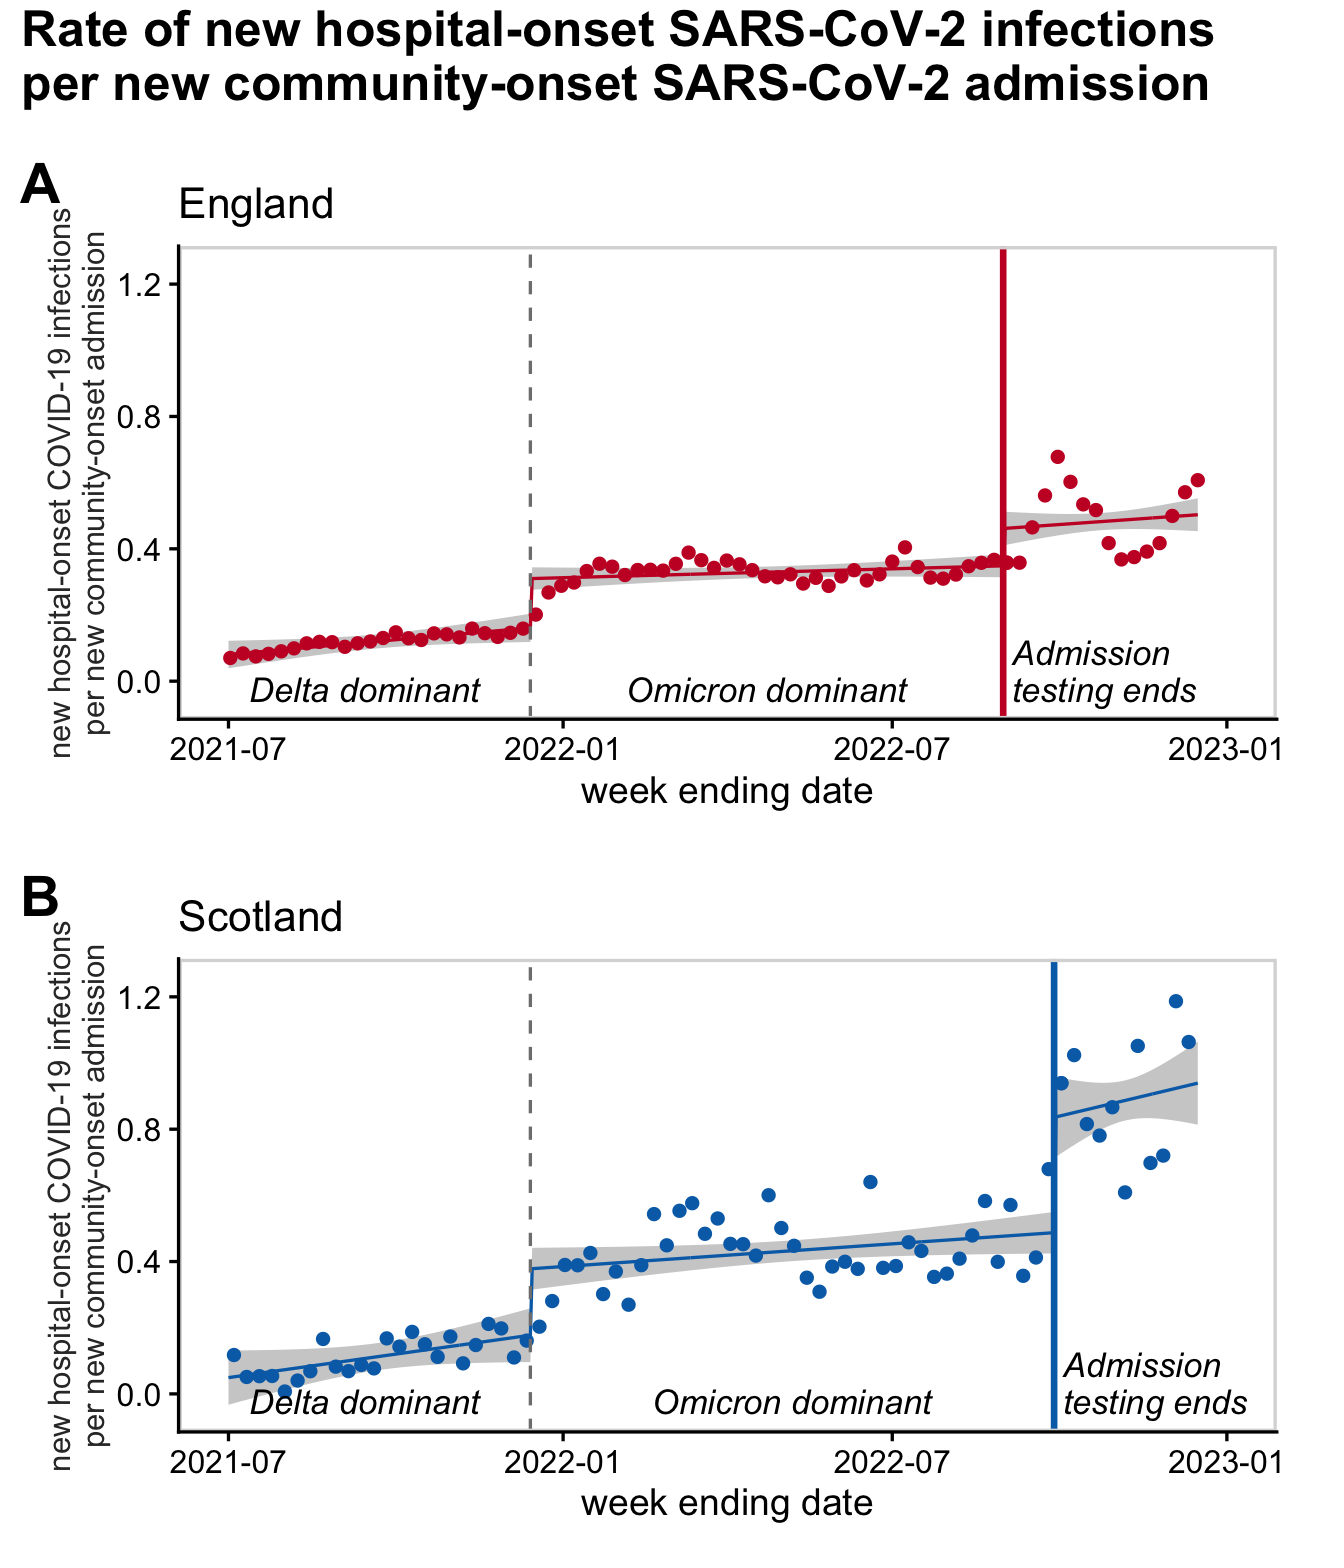

In [16]:
options(repr.plot.width=6, repr.plot.height=7)

country_colors <- c("#c8102e", "#006eb6")
names(country_colors) <- levels(dt.fix$region)

ho_co_ratio_plot <- function(dt) {
    reg <- dt$region[1]
    asx_testing_stopped <- dt.asx_test_stopped[region == reg, stop_date]
    ggplot(dt[date >= date_study_start & date <= date_study_end, ], aes(x = date, color = region)) +
        geom_ribbon(data = dt.predict[region == reg], aes(ymax = gls.its.hoco.ci95_hi, ymin = gls.its.hoco.ci95_lo), 
            color = NA, alpha = 0.4, fill = "grey50") +
        geom_line(data = dt.predict[region == reg], aes(y = gls.its.hoco)) +
        geom_point(aes(y=hospital_onset_vs_comm_ratio)) + 
        geom_vline(data = dt.asx_test_stopped[region == reg, ], aes(xintercept = stop_date, color = region), 
            linetype = "solid", size = 1, show.legend = FALSE) +
        geom_vline(xintercept = date_omicron_takeover, color = "gray50", linetype = "dashed", size = 0.5) +
        scale_color_manual(values = country_colors) +
        ylab("new hospital-onset COVID-19 infections\nper new community-onset admission") +
        xlab("week ending date") + ylim(-0.05, 1.25) + 
        xlim(as.Date("2021-07-01"), as.Date("2023-01-01")) +
        ggtitle(reg) + 
        theme_cowplot(12) + panel_border() +
        theme(
            legend.position = "none",
            plot.margin = margin(0.2, 0.3, 0.2, 0.2, "in"),
            plot.title = element_text(face = "plain"),
            panel.spacing = unit(2, "lines"),
            axis.title.y = element_text(color = "grey20", size = 10, angle = 90, hjust = .5, vjust = .5, face = "plain")
        ) +
        draw_label("Delta dominant", x = as.Date('2021-09-14'), vjust = 0, y = -0.06, size = 11, fontface = "italic") +
        draw_label("Omicron dominant", x = (asx_testing_stopped - date_omicron_takeover) * 0.5 + date_omicron_takeover, 
            vjust = 0, y = -0.06, size = 11, fontface= "italic") +
        draw_label("Admission\ntesting ends", x = asx_testing_stopped + 5, hjust = 0, vjust = 0, y = -0.06, size = 11, 
            fontface= "italic")
}

dt.fix.by_region <- split(dt.fix, dt.fix$region)
plts.fix.by_region <- lapply(dt.fix.by_region, ho_co_ratio_plot)

p0 <- ggplot() + labs(title = "Rate of new hospital-onset SARS-CoV-2 infections\nper new community-onset SARS-CoV-2 admission") + theme_map(14)
p1 <- plot_grid(plotlist = plts.fix.by_region, ncol = 1, labels = c('A', 'B'), label_size = 18)
plot_grid(p0, p1, ncol = 1, rel_heights = c(0.1, 1))

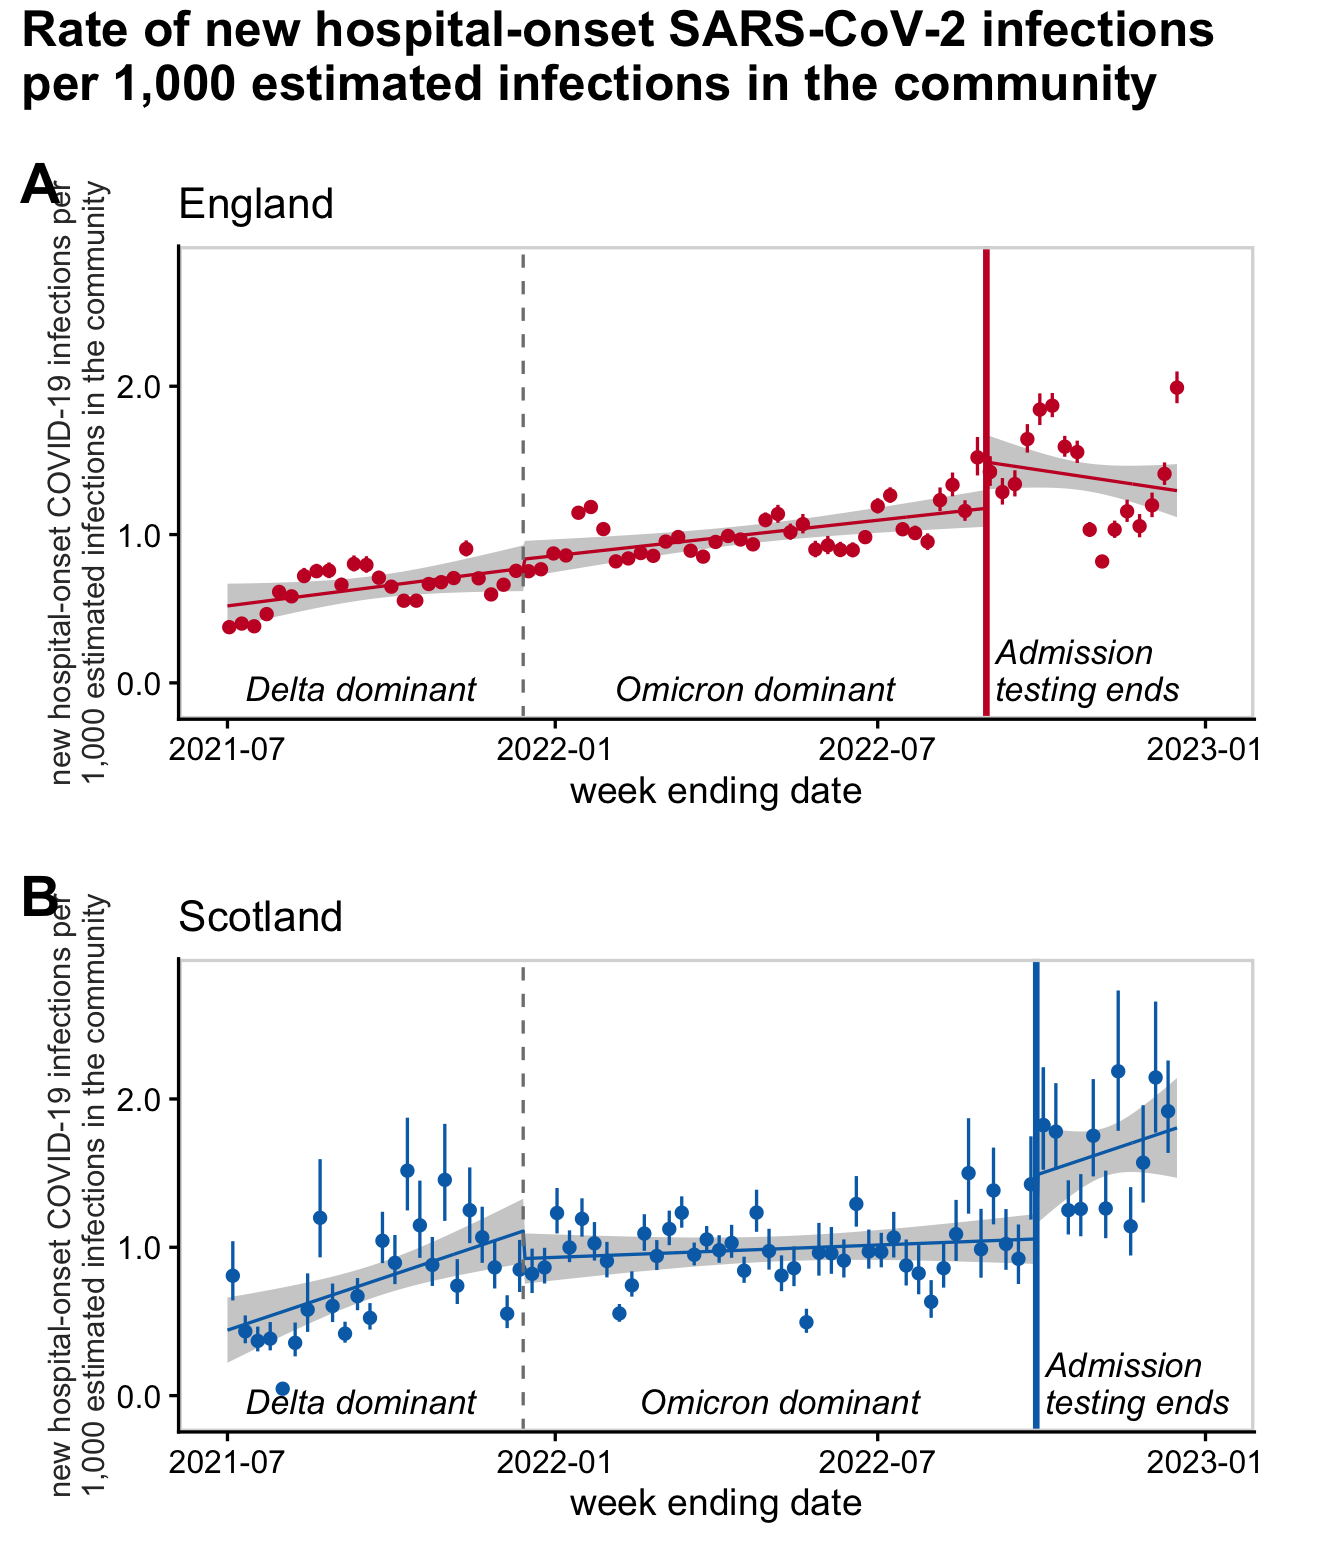

In [17]:
options(repr.plot.width=6, repr.plot.height=7)
y_scaling = 1e3

ho_vs_comm_positives_ratio_plot <- function(dt) {
    reg <- dt$region[1]
    asx_testing_stopped <- dt.asx_test_stopped[region == reg, stop_date]
    ggplot(dt[date >= date_study_start & date <= date_study_end, ], 
            aes(x = date, color = region)) +
        geom_ribbon(data = dt.predict[region == reg], aes(ymax = gls.its.hopos.ci95_hi, ymin = gls.its.hopos.ci95_lo), 
            color = NA, alpha = 0.4, fill = "grey50") +
        geom_line(data = dt.predict[region == reg], aes(y = gls.its.hopos)) +
        geom_point(aes(y=hospital_onset_vs_comm_positives * y_scaling)) + 
        geom_linerange(aes(
            ymin = hospital_onset_vs_comm_positives_ci95_lo * y_scaling, 
            ymax = hospital_onset_vs_comm_positives_ci95_hi * y_scaling
        )) +
        geom_vline(data = dt.asx_test_stopped[region == reg, ], aes(xintercept = stop_date, color = region), 
            linetype = "solid", size = 1, show.legend = FALSE) +
        geom_vline(xintercept = date_omicron_takeover, color = "gray50", linetype = "dashed", size = 0.5) +
        scale_color_manual(values = country_colors, name = "Country") +
        scale_y_continuous(name = "new hospital-onset COVID-19 infections per\n1,000 estimated infections in the community", 
            limits = c(-0.1, 2.8), labels = function(y) sprintf("%.1f", y)) +
        xlab("week ending date") + xlim(as.Date("2021-07-01"), as.Date("2023-01-01")) +
        ggtitle(reg) + 
        theme_cowplot(12) + panel_border() +
        theme(
            legend.position = "none",
            plot.margin = margin(0.2, 0.4, 0.2, 0.2, "in"),
            plot.title = element_text(face = "plain"),
            axis.title.y = element_text(color = "grey20", size = 10, angle = 90, hjust = .5, vjust = .5, face = "plain")
        ) + 
        draw_label("Delta dominant", x = as.Date('2021-09-14'), vjust = 0, y = -0.12, size = 11, fontface= "italic") +
        draw_label("Omicron dominant", x = (asx_testing_stopped - date_omicron_takeover) * 0.5 + date_omicron_takeover, 
            vjust = 0, y = -0.12, size = 11, fontface= "italic") +
        draw_label("Admission\ntesting ends", x = asx_testing_stopped + 5, hjust = 0, vjust = 0, y = -0.12, size = 11, fontface= "italic")
}

dt.fix.ons.by_region <- split(dt.fix.ons, dt.fix.ons$region)
plts.fix.ons.by_region <- lapply(dt.fix.ons.by_region, ho_vs_comm_positives_ratio_plot)

p0 <- ggplot() + labs(title = "Rate of new hospital-onset SARS-CoV-2 infections\nper 1,000 estimated infections in the community") + theme_map(14)
p1 <- plot_grid(plotlist = plts.fix.ons.by_region, ncol = 1, labels = c('A', 'B'), label_size = 18)
plot_grid(p0, p1, ncol = 1, rel_heights = c(0.1, 1))

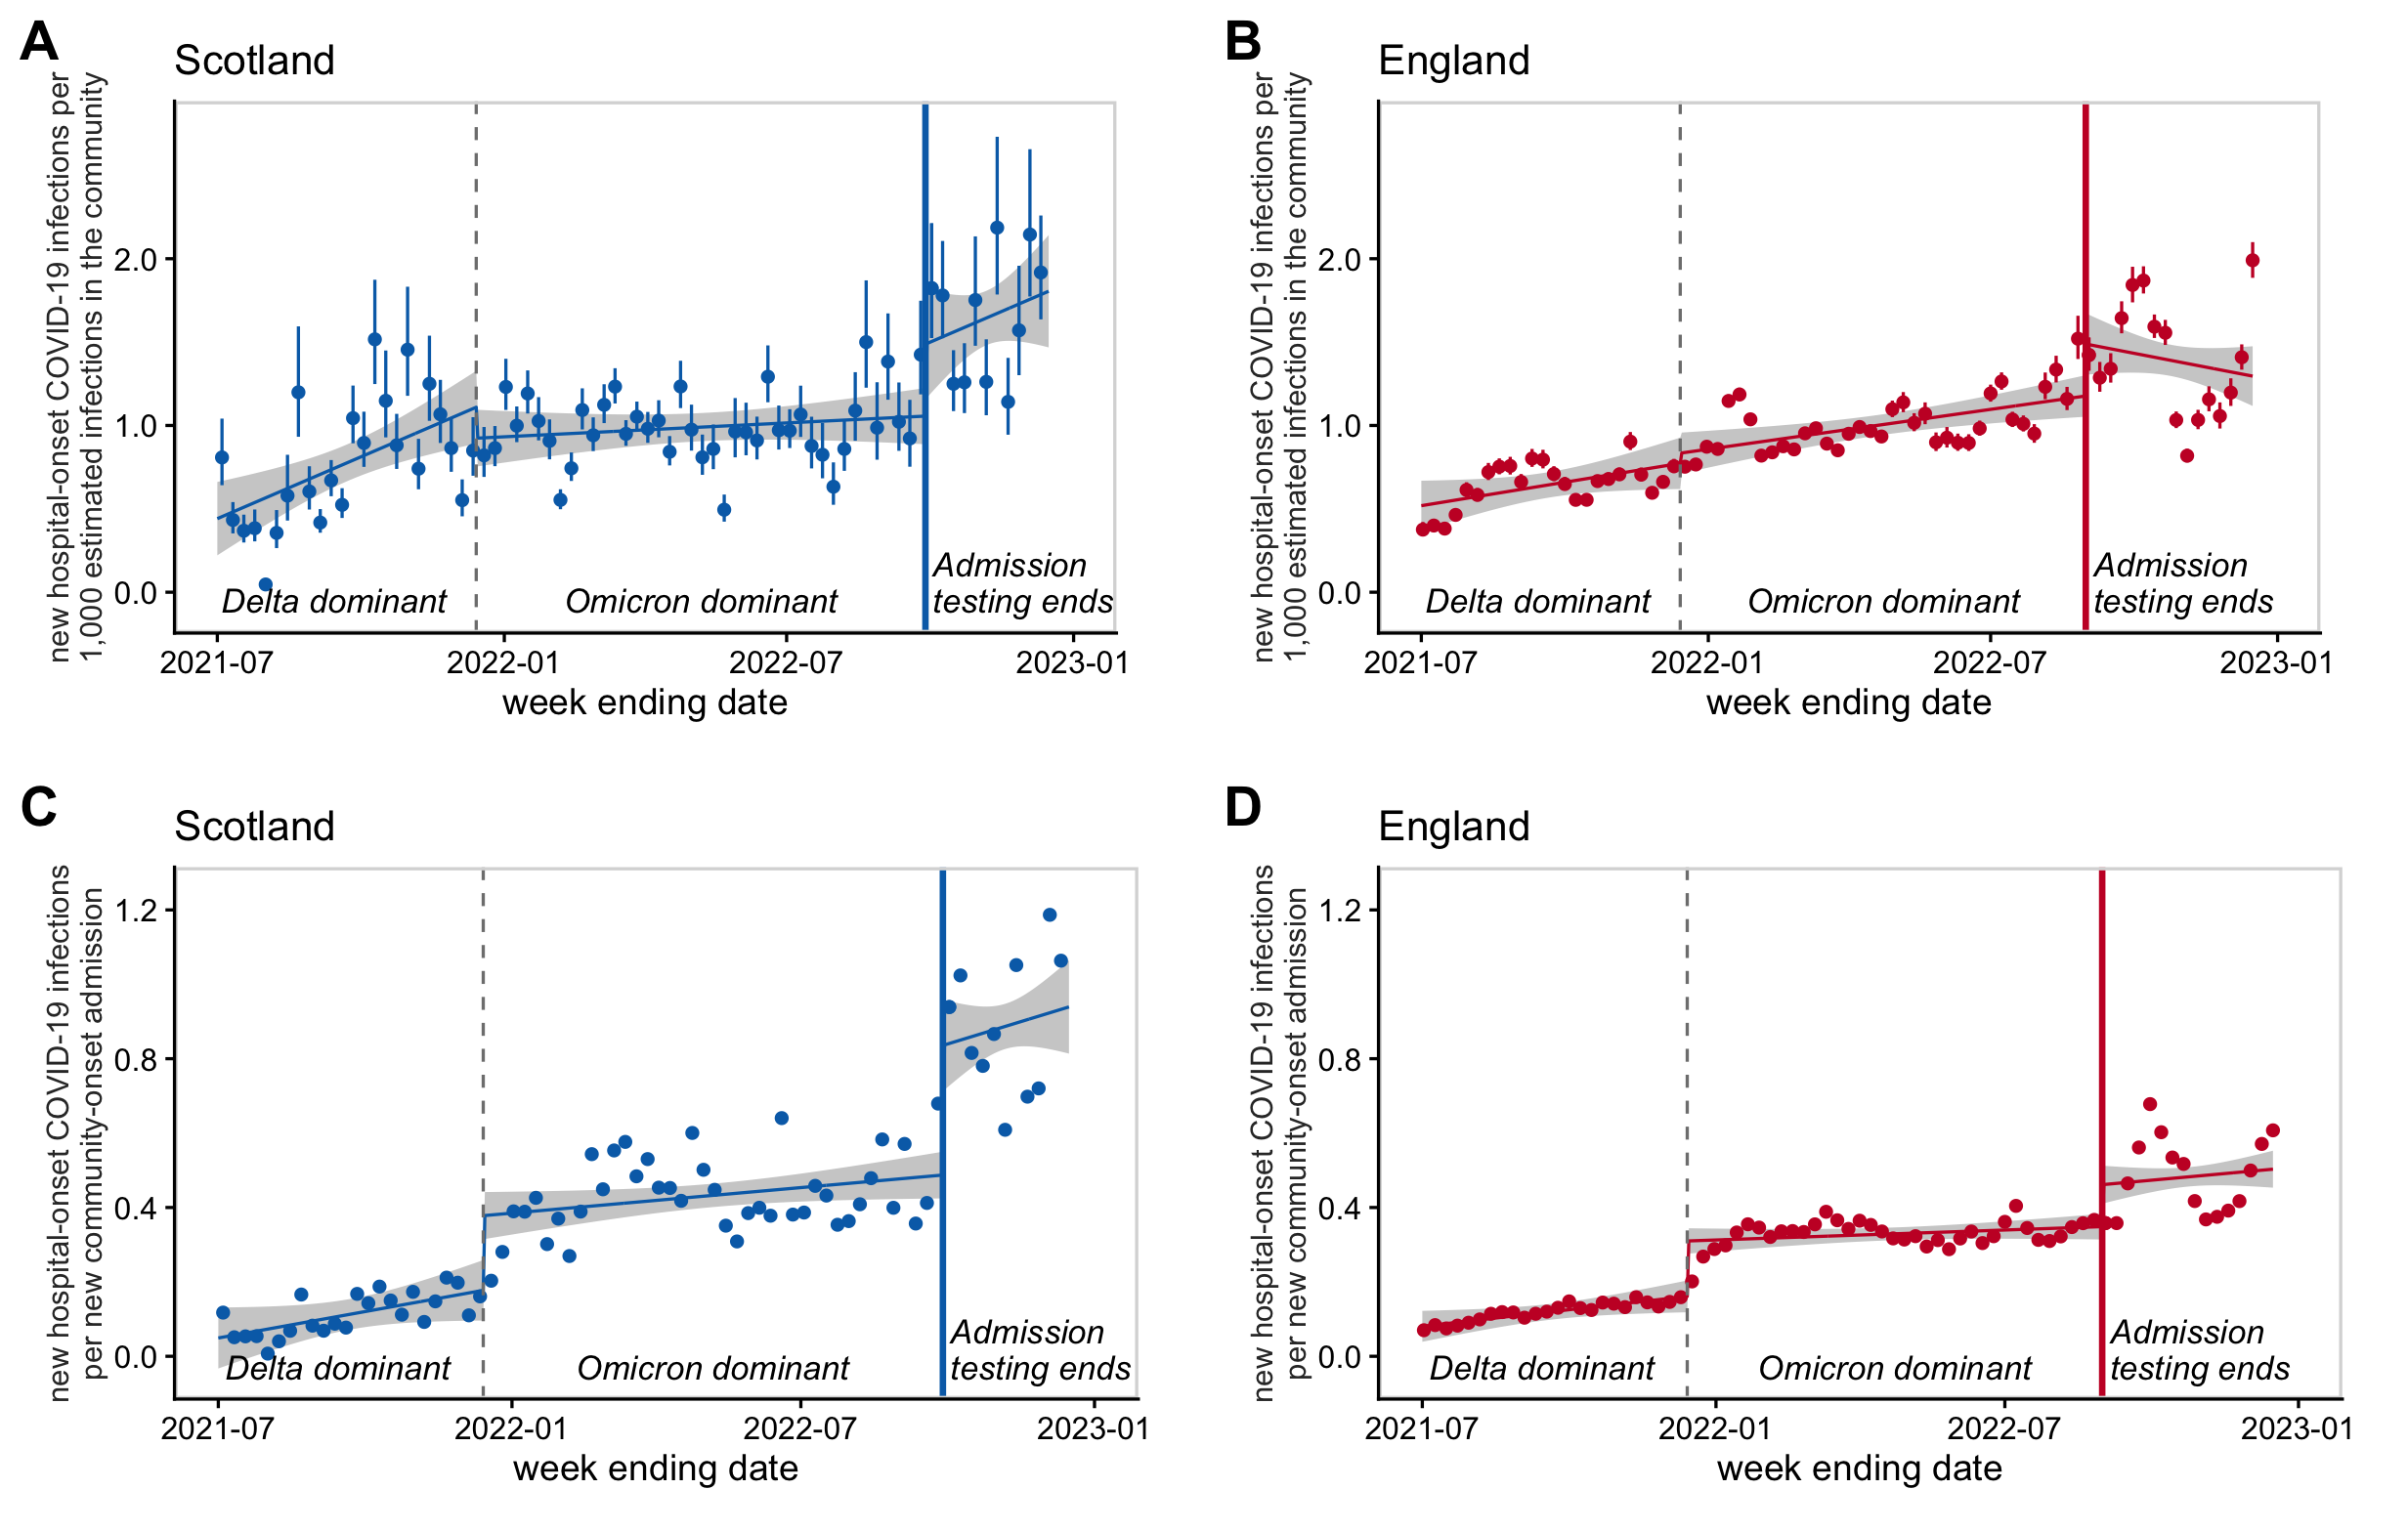

In [18]:
options(repr.plot.width=11, repr.plot.height=7)
p2x2 <- plot_grid(plotlist = rev(c(plts.fix.by_region, plts.fix.ons.by_region)), ncol = 2, labels = c('A', 'B', 'C', 'D'), label_size = 18)
p2x2

## sessionInfo

In [19]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] AICcmodavg_2.3-1  nlme_3.1-157      lubridate_1.8.0   cowplot_1.1.1    
 [5] yaml_2.3.5        viridis_0.6.2     viridisLite_0.4.1 readxl_1.4.1     
 [9] data.table_1.14.5 forcats_0.5.2     stringr_1.4.1     dplyr_1.0.10     
[13] purrr_1.0.0       readr_2.1.3       tidyr_1.2.1       tibble_3.1.8     
[17] ggplot2_3.4.0     tidyverse_1.3.2   plyr_1.8.7       

loaded via a namespace (and not attached):
 [1] httr_1.4.4          VGAM_1.1-7          jsonlite_1.8.0     
 [4] splines_4.2.1       modelr_0.1.9        assertthat_0.